In [20]:
from collections import defaultdict
import math
import os

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
from scipy import stats

In [78]:
SAMPLES = os.listdir('../raw/')
SAMPLES

['polya-untreated',
 'polya-siLuc',
 'polya-siLin28a',
 'clip-35L33G',
 'rpf-siLuc',
 'rpf-siLin28a']

# 1. Bam --> {sample : {gene ID : read count}}

In [4]:
def read_count_per_gene(fileIn):
    iterBam       = pysam.AlignmentFile(fileIn, 'rb')
    dctReads      = remove_multimapped_reads(iterBam)
    dctGenes      = ignore_redundant_isoforms(dctReads)
    dctReadCounts = count_reads(dctGenes)
    return dctReadCounts

In [5]:
def remove_multimapped_reads(iterBam):
    dctReads = defaultdict(set)
    for read in iterBam:
        if read.flag & 4 == 4: # FLAG 4 == unmapped
            continue # Ignore unmapped
        gene = read.reference_name.split('|')[1]
        dctReads[read.query_name].add(gene)
    dctReadsFiltered = {}
    for read, genes in dctReads.items():
        if len(genes) == 1:
            for gene in genes:
                dctReadsFiltered[read] = gene
    return dctReadsFiltered

In [6]:
def ignore_redundant_isoforms(dctReads):
    dctGenes = defaultdict(set)
    for read, gene in dctReads.items():
        dctGenes[gene].add(read)
    return dctGenes

In [7]:
def count_reads(dctGenes):
    dctReadCounts = {}
    for gene, reads in dctGenes.items():
        dctReadCounts[gene] = len(reads)
    return dctReadCounts

In [8]:
dctSamples = {}
for sample in SAMPLES:
    dctSamples[sample] = read_count_per_gene(f'../alignments/{sample}.bam')
    print(f'count {sample}: complete!')

count polya-untreated: complete!
count polya-siLuc: complete!
count polya-siLin28a: complete!
count clip-35L33G: complete!
count rpf-siLuc: complete!
count rpf-siLin28a: complete!


# 2. Make dataframe

## 2.1. Make and save dataframe

In [11]:
dfCounts = pd.DataFrame(dctSamples)
dfCounts.to_csv('read-count.txt', sep='\t')
dfCounts

,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
ENSMUSG00000095126.4,NaN,NaN,NaN,NaN,NaN,1.0
ENSMUSG00000083561.4,NaN,NaN,NaN,NaN,NaN,1.0
ENSMUSG00000116647.2,NaN,NaN,NaN,NaN,NaN,1.0
ENSMUSG00000088776.3,NaN,NaN,NaN,NaN,NaN,1.0


## 2.2. Discard genes with NaN

In [16]:
dfFiltered = dfCounts.dropna(axis=0)
dfFiltered

,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
ENSMUSG00000031089.8,1.0,3.0,4.0,15.0,5.0,15.0
ENSMUSG00000001773.15,1.0,1.0,9.0,20.0,9.0,16.0
ENSMUSG00000085485.2,1.0,3.0,1.0,4.0,2.0,4.0
ENSMUSG00000117637.2,1.0,1.0,2.0,9.0,1.0,1.0


## 2.2. Discard genes with low read counts

In [17]:
RPF_CUTOFF  = 80
CLIP_CUTOFF = 30

In [18]:
dfFiltered = dfFiltered[dfFiltered['rpf-siLuc'] >= RPF_CUTOFF]\
                       [dfFiltered['clip-35L33G'] >= CLIP_CUTOFF]
dfFiltered

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
ENSMUSG00000060981.8,5.0,7.0,5.0,462.0,6718.0,4907.0
ENSMUSG00000108599.2,6.0,19.0,17.0,110.0,1706.0,1391.0
ENSMUSG00000055775.17,2.0,43.0,13.0,55.0,1287.0,669.0
ENSMUSG00000114279.2,2.0,3.0,3.0,722.0,3482.0,2083.0


# 3. Plot Figure 4D

In [24]:
PSEUDO = 0.01
pseudoLog2 = lambda x: math.log2(x + PSEUDO)

In [25]:
seClip = dfFiltered['clip-35L33G'].apply(pseudoLog2).sub(dfFiltered['polya-untreated'].apply(pseudoLog2))
seClip

ENSMUSG00000038697.16    0.190190
ENSMUSG00000033906.6     1.377959
ENSMUSG00000042770.9    -1.087413
ENSMUSG00000043716.14   -0.773587
ENSMUSG00000040481.18    0.132062
                           ...   
ENSMUSG00000060981.8     6.526970
ENSMUSG00000108599.2     4.194126
ENSMUSG00000055775.17    4.774426
ENSMUSG00000114279.2     8.488680
ENSMUSG00000069265.3     7.345995
Length: 8016, dtype: float64

In [26]:
seSiLin28a = dfFiltered['rpf-siLin28a'].apply(pseudoLog2).sub(dfFiltered['polya-siLin28a'].apply(pseudoLog2))
seSiLin28a

ENSMUSG00000038697.16    -1.664248
ENSMUSG00000033906.6     -0.438343
ENSMUSG00000042770.9     -0.422611
ENSMUSG00000043716.14    -1.416652
ENSMUSG00000040481.18    -3.452192
                           ...    
ENSMUSG00000060981.8      9.935818
ENSMUSG00000108599.2      6.353606
ENSMUSG00000055775.17     5.684335
ENSMUSG00000114279.2      9.434691
ENSMUSG00000069265.3     10.554261
Length: 8016, dtype: float64

In [27]:
seSiLuc = dfFiltered['rpf-siLuc'].apply(pseudoLog2).sub(dfFiltered['polya-siLuc'].apply(pseudoLog2))
seSiLuc

ENSMUSG00000038697.16    -1.162368
ENSMUSG00000033906.6     -0.250209
ENSMUSG00000042770.9      0.579839
ENSMUSG00000043716.14    -0.271036
ENSMUSG00000040481.18    -2.291568
                           ...    
ENSMUSG00000060981.8      9.904404
ENSMUSG00000108599.2      6.487724
ENSMUSG00000055775.17     4.903207
ENSMUSG00000114279.2     10.175941
ENSMUSG00000069265.3     12.609071
Length: 8016, dtype: float64

In [28]:
seRpf = seSiLin28a.sub(seSiLuc)
seRpf

ENSMUSG00000038697.16   -0.501880
ENSMUSG00000033906.6    -0.188133
ENSMUSG00000042770.9    -1.002450
ENSMUSG00000043716.14   -1.145616
ENSMUSG00000040481.18   -1.160624
                           ...   
ENSMUSG00000060981.8     0.031414
ENSMUSG00000108599.2    -0.134118
ENSMUSG00000055775.17    0.781128
ENSMUSG00000114279.2    -0.741251
ENSMUSG00000069265.3    -2.054811
Length: 8016, dtype: float64

Text(1.5, -2.7, '$r$ = 0.4883')

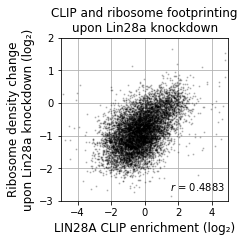

In [77]:
fig4, axd = plt.subplots(nrows=1, ncols=1, figsize=(3,3))

axd.scatter(x=seClip, y=seRpf, s=1, alpha=0.2, color='black', zorder=10)
axd.set_xlim(-5, 5)
axd.set_ylim(-3, 2)

axd.grid(axis='both', zorder=1)

axd.set_title('CLIP and ribosome footprinting\nupon Lin28a knockdown', fontsize=12)
axd.set_xlabel('LIN28A CLIP enrichment (log\u2082)', fontsize=12)
axd.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log\u2082)', fontsize=12)
fCorr = round(stats.pearsonr(seClip, seRpf)[0], 4)
axd.text(1.5, -2.7, r'$r$' + f' = {fCorr}')

# 4. GO terms

to do